In [168]:
### DEFINITIONS ###
import harp
import pandas as pd 

FOLDER = "olfactometer_13A_2025-11-06T052526Z"
PATH = "C:/Data/Olfact/" + FOLDER  

# Containers
RegisterDict = {}

In [169]:
### ADD ANALOG DATA TO REGLIST ###
AlogReader = harp.create_reader(PATH+ "/behavior/AnalogInput.harp", include_common_registers=False)
RegisterDict['Analog'] = AlogReader.AnalogData.read()['Channel0']

In [170]:
### ADD OLFACTOMETER DATA TO REGLIST ###
OlfReader = harp.create_reader(PATH + "/behavior/Olfactometer.harp", include_common_registers=False)

# Loop through all olfactometer registers
for name, reg in OlfReader.registers.items():
    RegisterDict[name] = reg.read()

In [171]:
### FILTERING ANALOG SIGNAL AND CALCULATING DERIVATIVES ###
import pandas as pd
import numpy as np
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

# Extract time and values
timestamp: pd.Index = RegisterDict['Analog'].index
analog_signal: np.ndarray = RegisterDict['Analog'].values

# --- STEP 1: Resample to 100 Hz ---
# Original timestamps are in seconds; create new time grid
new_rate = 100  # Hz
new_time = np.arange(timestamp[0], timestamp[-1], 1/new_rate)

# Interpolate signal to new time grid
analog_resampled = np.interp(new_time, timestamp, analog_signal)

# --- STEP 2: Apply filter (choose one option) ---
# Option 1: Median filter (best for removing spikes without overshoot)
# analog_smoothed = medfilt(analog_resampled, kernel_size=51)

# Option 2: Rolling mean (simple smoothing)
# analog_smoothed = pd.Series(analog_resampled).rolling(window=3, center=True).mean().ffill().bfill().values

# Option 3: Gaussian filter (smooth but preserves shape)
analog_smoothed = gaussian_filter1d(analog_resampled, sigma=40)

# --- STEP 3: Compute derivatives ---
analog_slope = np.gradient(analog_smoothed, new_time, edge_order=2).round()
analog_secder = np.gradient(analog_slope, new_time, edge_order=2).round()

# --- STEP 4: Store in RegisterDict ---
RegisterDict['AnalogResampled']= pd.DataFrame({'Resampled': analog_resampled}, index=new_time)
RegisterDict['AnalogSmoothed'] = pd.DataFrame({'Smoothed': analog_smoothed}, index=new_time)
RegisterDict['Analog_Slope']   = pd.DataFrame({'Slope': analog_slope}, index=new_time)
RegisterDict['Analog_SDer']    = pd.DataFrame({'SecondDerivative': analog_secder}, index=new_time)


In [172]:
### SAVING DATA TO A CSV ###

RegisterDict['AnalogResampled'].to_csv('saved/AnalogResampled.csv', index=True)
RegisterDict['AnalogSmoothed'].to_csv('saved/AnalogSmoothed.csv', index=True)
RegisterDict['Analog_Slope'].to_csv('saved/Analog_Slope.csv', index=True)
RegisterDict['Analog_SDer'].to_csv('saved/Analog_SDer.csv', index=True)

In [173]:
### ZEROING AND ROUNDING TIMESTAMP TO MS ###
start = RegisterDict['Analog'].index[0]

for reg in RegisterDict:
    RegisterDict[reg].index = (RegisterDict[reg].index - start).round(3)

Found 63 maxima and 64 minima in 'Slope'


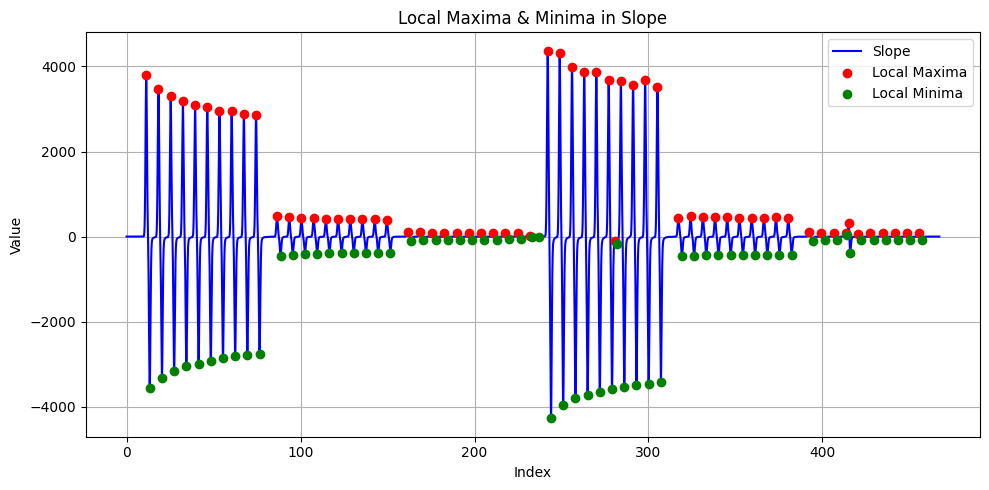

In [174]:
### FIND LOCAL MAX-MIN TO LOCATE THE START AND THE END OF THE PULSES ###
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming df is a pandas Series or single-column DataFrame
df = RegisterDict['Analog_Slope']

# If it's a DataFrame, extract the only column
if isinstance(df, pd.DataFrame):
    signal = df.iloc[:, 0].values
    timestamp = df.index.values
    col_name = df.columns[0]
else:
    signal = df.values
    timestamp = df.index.values
    col_name = getattr(df, 'name', 'Analog')

# Parameters to tune
PROMINENCE = 10     # Minimum prominence (height difference) for a peak
DISTANCE = 100

# --- Detect maxima and minima ---
max_indices, _ = find_peaks(signal, prominence=PROMINENCE, distance=DISTANCE)
min_indices, _ = find_peaks(-signal, prominence=PROMINENCE, distance=DISTANCE)

# --- Build results DataFrame ---
pulses_df = pd.DataFrame({
    'PulseStart': False,
    'PulseEnd': False
}, index=timestamp)

pulses_df.loc[pulses_df.index[max_indices], 'PulseStart'] = True
pulses_df.loc[pulses_df.index[min_indices], 'PulseEnd'] = True

# --- Print summary ---
print(f"Found {len(max_indices)} maxima and {len(min_indices)} minima in '{col_name}'")

# --- Plot results ---
plt.figure(figsize=(10, 5))
plt.plot(timestamp, signal, label=col_name, color='blue')
plt.scatter(timestamp[max_indices], signal[max_indices], color='red', label='Local Maxima', zorder=5)
plt.scatter(timestamp[min_indices], signal[min_indices], color='green', label='Local Minima', zorder=5)

plt.title(f'Local Maxima & Minima in {col_name}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


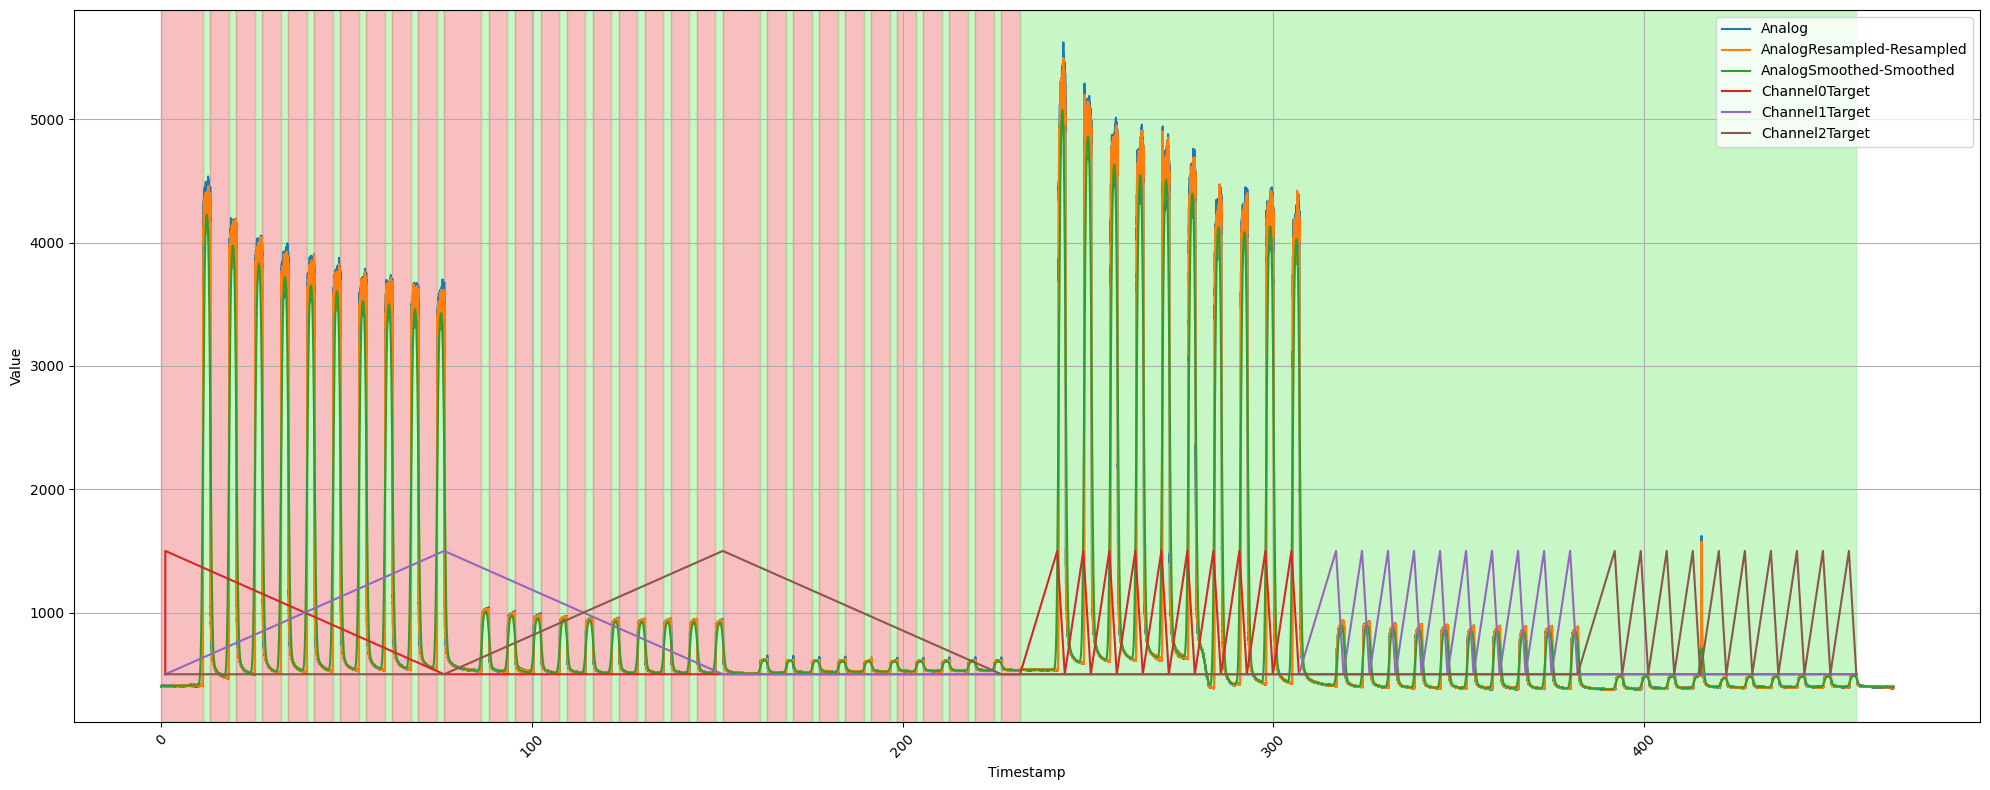

In [175]:
### GRAPH ###
import matplotlib.pyplot as plt

endvalve_df:pd.DataFrame = RegisterDict['EndValveState']
dict_to_graph = {
    # 'Flowmeter': RegList['Flowmeter'],
    'Analog':         RegisterDict['Analog'],
    'AnalogResampled':RegisterDict['AnalogResampled'],
    'AnalogSmoothed': RegisterDict['AnalogSmoothed'], 
    'Channel0Target': RegisterDict['ChannelsTargetFlow']['Channel0']*10+500, 
    'Channel1Target': RegisterDict['ChannelsTargetFlow']['Channel1']*10+500, 
    'Channel2Target': RegisterDict['ChannelsTargetFlow']['Channel2']*10+500, 
    # 'Channel4': RegisterDict['Channel4ActualFlow']*6 
}
fig, ax = plt.subplots(figsize=(20, 8))

for name, reg in dict_to_graph.items():
    if isinstance(reg, pd.DataFrame):
        for col in reg.columns:
            plt.plot(reg.index, reg[col], label=f"{name}-{col}")
    elif isinstance(reg, pd.Series):
        plt.plot(reg.index, reg.values, label=f"{name}")

# Add background color based on endvalve state (geeen on, red off)
endvalve_state = False
start_time = RegisterDict['Analog'].index[0]
for i in range(1, len(endvalve_df)):
    if endvalve_df['EndValve0'].iloc[i] != endvalve_state:
        color = 'lightgreen' if endvalve_state else 'lightcoral'
        ax.axvspan(start_time, endvalve_df.index[i], color=color, alpha=0.5)
        endvalve_state = endvalve_df['EndValve0'].iloc[i]
        start_time = endvalve_df.index[i]
# Draw last region
color = 'lightgreen' if endvalve_state else 'lightcoral'
ax.axvspan(start_time, endvalve_df.index[-1], color=color, alpha=0.5)

# Formatting
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
ax.set_title('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


In [176]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.DataFrame(RegisterDict['Analog'])  # Original signal. Pulses from a baseline
# pulses_df From slope analysis, info on when the pulse starts and when it ends (approximatelly)

def linear_fit(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    return model.coef_[0], model.intercept_

def get_open_status(df:pd.DataFrame, query_time:float, columns:list[str] = None):
    """
    Given a DataFrame with time-indexed or time-column data, returns which channel/valve is 
    active (non-zero or True), its value, and how long it has been active.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain a time column ('Time') or a time index.
    query_time : float
        Time at which to check status.
    columns : list of str, optional
        Columns to check (default: all columns except 'Time')
    
    Returns
    -------
    list or None
        ['channel', 'value', 'elapsed_time']
    """
    # If 'Time' is an index, convert it into a column for easier access
    if 'Time' not in df.columns:
        df = df.reset_index()

    df = df.sort_values('Time').reset_index(drop=True)

    # Default columns = all except 'Time'
    if columns is None:
        columns = [c for c in df.columns if c != 'Time']

    # Find the most recent row before or at the given time
    valid_rows = df[df['Time'] <= query_time]
    if valid_rows.empty:
        return [None, None, -1, -1]
    current_row = valid_rows.iloc[-1]

    # Determine active (True or nonzero) columns
    active_cols = []
    for c in columns:
        val = current_row[c]
        if isinstance(val, (bool, np.bool_)):
            if val:
                active_cols.append(c)
        elif isinstance(val, (int, float)) and val != 0:
            active_cols.append(c)

    if len(active_cols)>1:
        print(f"Warning! At {query_time}s there is more than one channel open: {active_cols}")

    if active_cols:
        # Find when it last became active
        col = active_cols[0]
        val = current_row[col]
        current_time = current_row['Time']

        # Slice the dataframe up to and including current_time
        df_slice = df[df['Time'] <= current_time]

        # Reverse iterate to find when it changed from inactive to active
        open_time = df_slice.iloc[-1]['Time']  # default to current_time
        for i in range(len(df_slice) - 2, -1, -1):
            prev_val = df_slice.iloc[i][col]
            if isinstance(prev_val, (bool, np.bool_)) and not prev_val:
                open_time = df_slice.iloc[i + 1]['Time']
                break
            elif isinstance(prev_val, (int, float)) and prev_val == 0:
                open_time = df_slice.iloc[i + 1]['Time']
                break
            elif i == 0:
                open_time = df_slice.iloc[0]['Time']
        
        val = int(current_row[col])
        elapsed = float(round(query_time - open_time,3))

    else:
        return [None, None, -1, -1]
    

    return [col, val, open_time, elapsed]

# Dynamic margins 
margin = 1.5   # Seconds before or after the pulse
plateau_margin = 0.10  # Margin on both sides of the plateau as % of pulse duration

slices_info = []

for pulse_start in pulses_df.index[pulses_df['PulseStart']]:
    
    # Compute dynamic timestamps
    next_pulse_end = pulses_df.index[(pulses_df.index > pulse_start) & pulses_df['PulseEnd']]
    if len(next_pulse_end) == 0:
        continue
    pulse_end = next_pulse_end[0]
    start_time = max(pulse_start - margin, df.index[0])
    end_time = min(pulse_end + margin, df.index[-1])
    slice_df:pd.DataFrame = df.loc[(df.index >= start_time) & (df.index <= end_time)]
    if slice_df.empty:
        continue

    pulse_center = pulse_start + 0.5 * (pulse_end - pulse_start)  

    first_half = slice_df.loc[(slice_df.index >= start_time) & (slice_df.index <= pulse_center)]
    second_half = slice_df.loc[(slice_df.index >= pulse_center) & (slice_df.index <= end_time)]

    first_half_q10 = np.percentile(first_half.iloc[:, 0], 10)
    first_half_q90 = np.percentile(first_half.iloc[:, 0], 90)
    second_half_q10 = np.percentile(second_half.iloc[:, 0], 10)
    second_half_q90 = np.percentile(second_half.iloc[:, 0], 90)

    trigger_val_start = first_half_q10 + (first_half_q90 - first_half_q10)/4 
    trigger_val_end= second_half_q10 + (second_half_q90 - second_half_q10)*3/4 

    #Recalculating real pulse start and end
    first_half_mask = first_half.iloc[:, 0] >= trigger_val_start # Create a mask
    pulse_start = first_half_mask.idxmax()
    second_half_mask = second_half.iloc[:, 0] <= trigger_val_end
    pulse_end = second_half_mask.idxmax()    
    
    start_time = max(pulse_start - margin, df.index[0])
    end_time = min(pulse_end + margin, df.index[-1])    
    slice_df = df.loc[(df.index >= start_time) & (df.index <= end_time)] 

    pulse_duration = pulse_end - pulse_start
    before_pulse_duration = after_pulse_duration = margin

    plateau_region_without_edges_start = pulse_start + plateau_margin * pulse_duration
    plateau_region_without_edges_end = pulse_end - plateau_margin * pulse_duration


    # Plateau Region
    plateau_region = slice_df.loc[(slice_df.index >= pulse_start) & (slice_df.index <= pulse_end)]
    plateau_region_without_edges = slice_df.loc[(slice_df.index >= plateau_region_without_edges_start) & (slice_df.index <= plateau_region_without_edges_end)]
    peak_value = plateau_region.iloc[:, 0].max()
    peak_idx = slice_df.iloc[:, 0].idxmax()
    plateau_mean = plateau_region_without_edges.iloc[:, 0].mean()
    plateau_q95 = np.quantile(plateau_region_without_edges, 0.95)
    plateau_slope, _ = linear_fit(plateau_region_without_edges.index.values, plateau_region_without_edges.iloc[:,0].values)

    # Before pulse Region
    before_pulse_region = slice_df.loc[(slice_df.index <= pulse_start)]
    before_pulse_slope, _ = linear_fit(before_pulse_region.index.values, before_pulse_region.iloc[:,0].values)
    before_pulse_mean = before_pulse_region.iloc[:, 0].mean()

    start_region = slice_df.iloc[:int(len(slice_df)*0.05)]
    start_region_slope, _ = linear_fit(start_region.index.values, start_region.iloc[:,0].values)
    start_region_mean = start_region.iloc[:, 0].mean()

    # After pulse Region
    after_pulse_region = slice_df.loc[(slice_df.index >= pulse_end)]
    after_pulse_slope, _ = linear_fit(after_pulse_region.index.values, after_pulse_region.iloc[:,0].values)
    after_pulse_mean = after_pulse_region.iloc[:, 0].mean()

    end_region = slice_df.iloc[-int(len(slice_df)*0.05):]
    end_region_slope, _ = linear_fit(end_region.index.values, end_region.iloc[:,0].values)
    end_region_mean = end_region.iloc[:, 0].mean()

    # Check Channels and envalve status [col, val, open_time, elapsed]
    active_channel, flow, t_active_channel, dt_active_channel = get_open_status(RegisterDict['ChannelsTargetFlow'], pulse_start, columns=['Channel0', 'Channel1', 'Channel2'])
    _, endvalve_state, t_active_endvalve, dt_active_endvalve = get_open_status(RegisterDict['EndValveState'], pulse_start)
    pulse_created_by_envalve = True if dt_active_endvalve < dt_active_channel else False
    
    # Area under and over the curve 
    pulse_auc = np.trapezoid(plateau_region.iloc[:, 0].to_numpy(), plateau_region.index.to_numpy()) - start_region_mean * pulse_duration  
    ideal_pulse_auc = (plateau_q95 - start_region_mean) * pulse_duration
    pulse_squareness = pulse_auc / ideal_pulse_auc
    
    before_pulse_auc = max(np.trapezoid(before_pulse_region.iloc[:, 0].to_numpy(), before_pulse_region.index.to_numpy()) - start_region_mean * before_pulse_duration, 0)
    after_pulse_auc = max(np.trapezoid(after_pulse_region.iloc[:, 0].to_numpy(), after_pulse_region.index.to_numpy()) - end_region_mean * after_pulse_duration, 0) 
    
    before_pulse_emptysquare = before_pulse_duration * (plateau_mean - start_region_mean)  
    after_pulse_emptysquare = after_pulse_duration * (plateau_mean - end_region_mean)  
    
    baselines_aoc = before_pulse_emptysquare - before_pulse_auc + after_pulse_emptysquare - after_pulse_auc 
    baselines_squareness = baselines_aoc / (before_pulse_emptysquare + after_pulse_emptysquare)
    
    # Squareness 
    squareness = pulse_squareness * baselines_squareness

    #Discard current pulse if is not above the baselines or if endvalve is not open
    if plateau_mean < before_pulse_mean * 1.05 or plateau_mean < after_pulse_mean * 1.05 or not endvalve_state or active_channel == None:
        print(f"Pulse in t={pulse_center} not valid")
    else:
        slices_info.append({
            'start_time': start_time,'end_time': end_time,

            'plateau_q95': plateau_q95,
            'plateau_mean': plateau_mean , 'before_baseline': start_region_mean, 'after_baseline': end_region_mean, 
            'plateau_slope': plateau_slope, 'start_region_slope': start_region_slope, 'end_region_slope': end_region_slope,
            'before_pulse_mean': before_pulse_mean, 'before_pulse_slope': before_pulse_slope, 
            'after_pulse_mean': after_pulse_mean, 'after_pulse_slope': after_pulse_slope,

            'trigger_val_start': trigger_val_start, 'trigger_val_end': trigger_val_end,
            'pulse_start': pulse_start, 'pulse_end': pulse_end, 'pulse_center': pulse_center,
            'peak_time': peak_idx, 'peak_value': peak_value,

            'pulse_squareness': pulse_squareness, 'baselines_squareness': baselines_squareness, 'squareness': squareness,

            'active_channel': active_channel, 't_active_channel': t_active_channel, 'dt_active_channel': dt_active_channel, 
            't_active_endvalve': t_active_endvalve, 'dt_active_endvalve': dt_active_endvalve, 'pulse_created_by_envalve': pulse_created_by_envalve,
    })

summary_df = pd.DataFrame(slices_info)


Pulse in t=232.415 not valid
Pulse in t=281.15 not valid
Pulse in t=413.78 not valid
Pulse in t=415.51 not valid


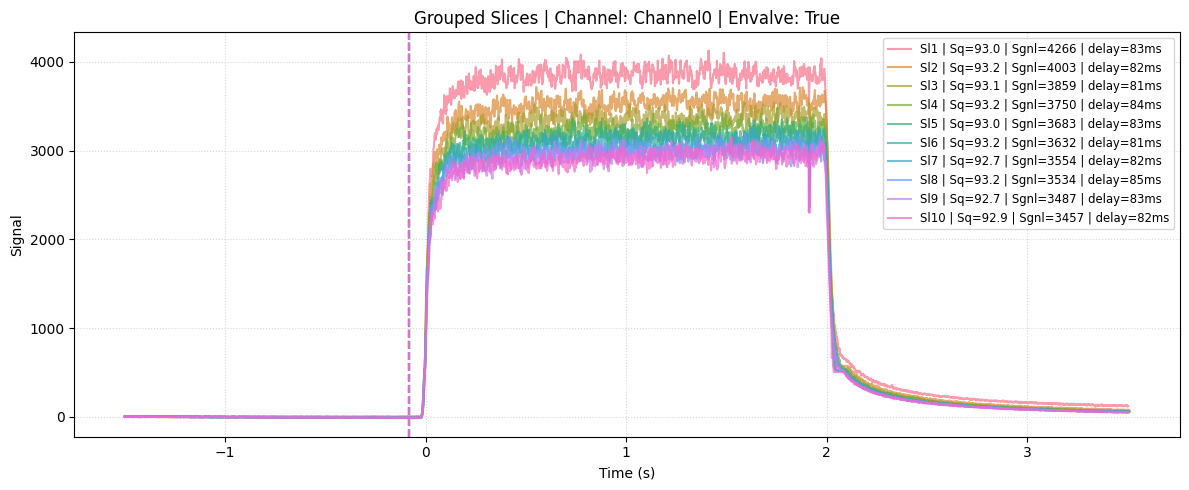

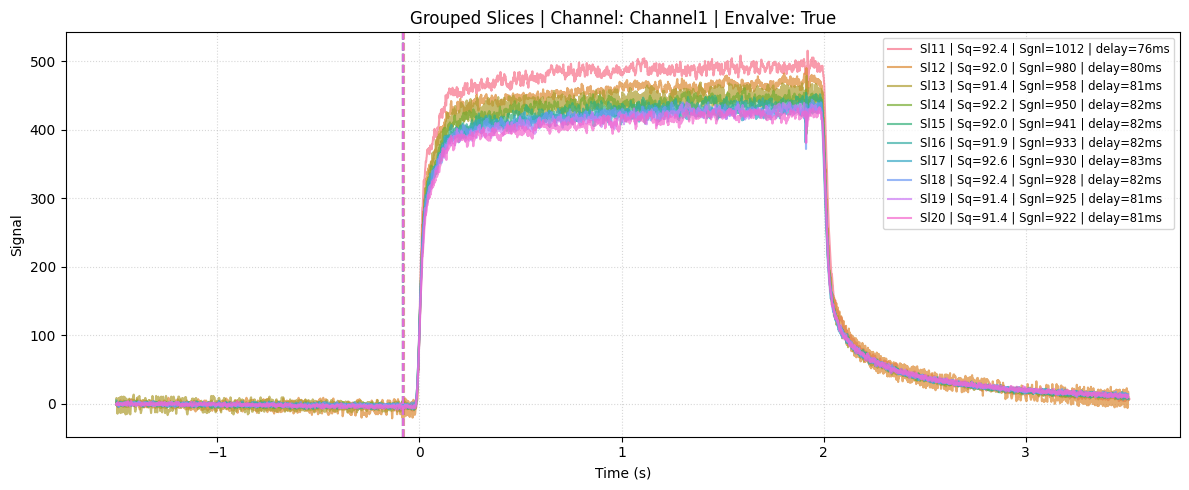

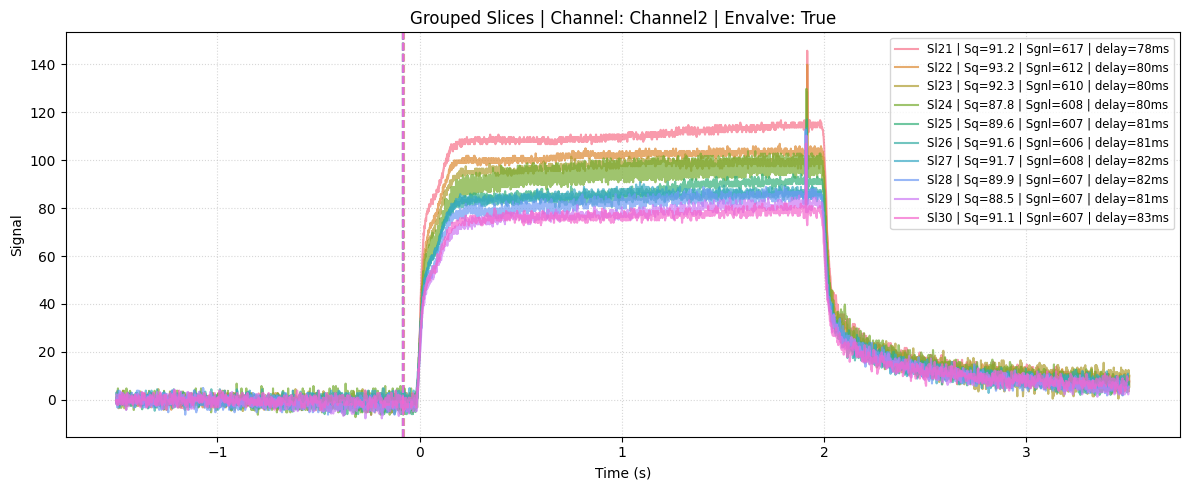

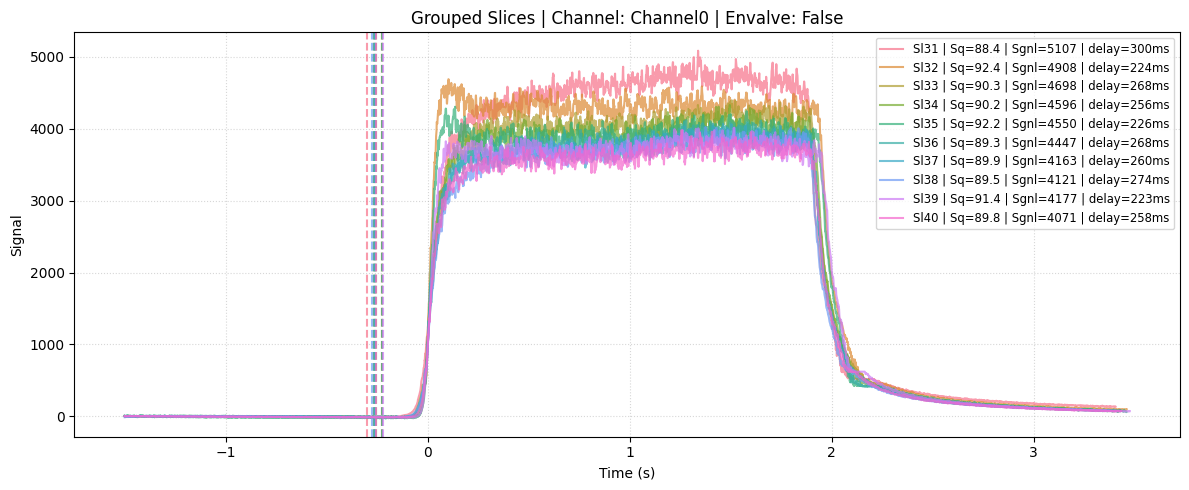

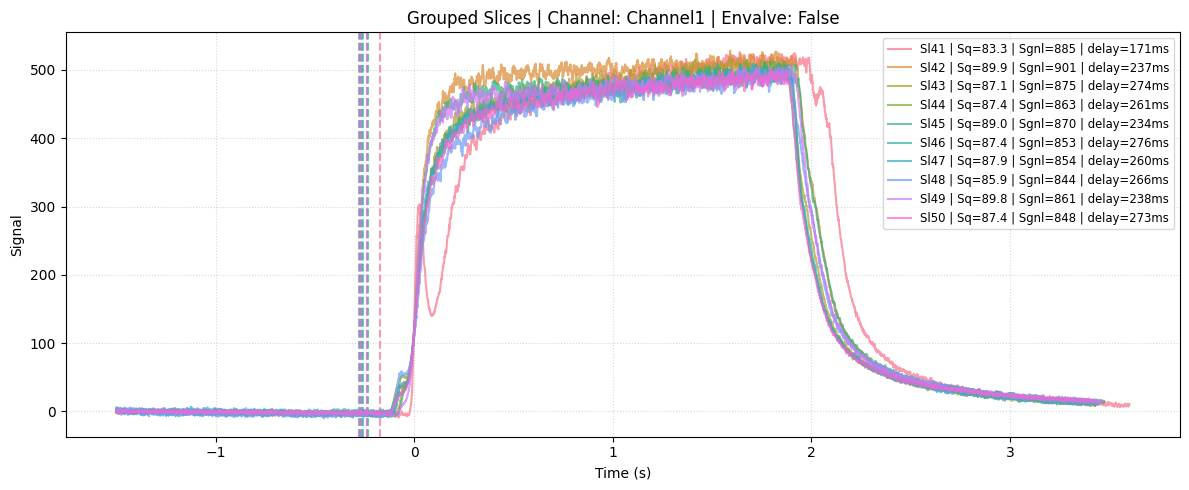

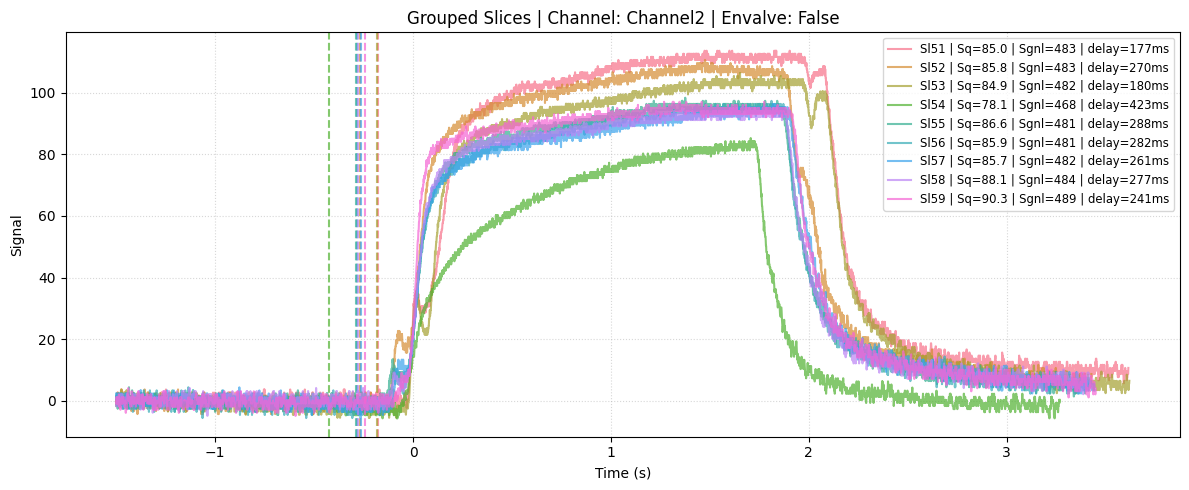

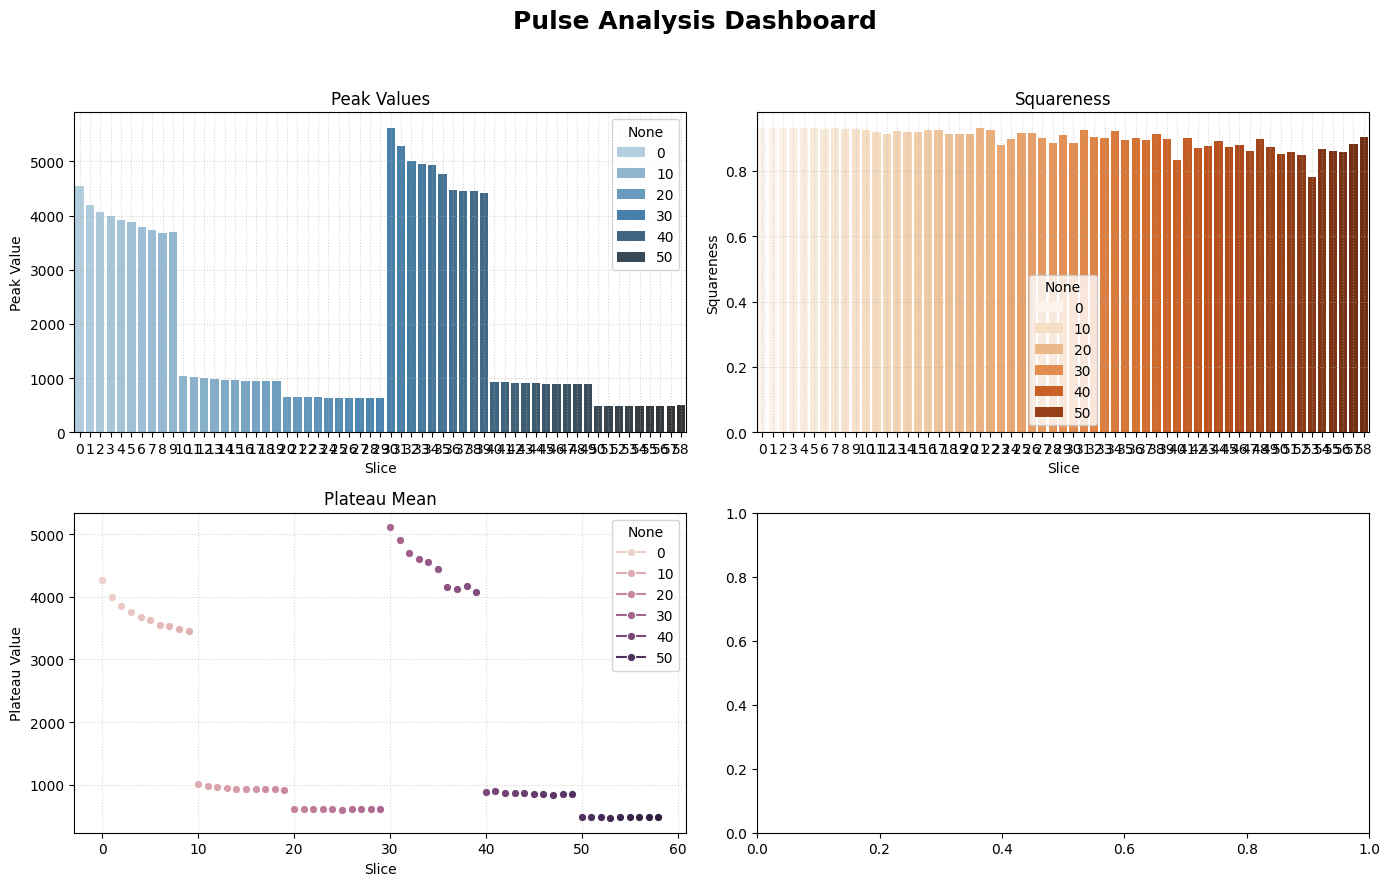

In [178]:
import matplotlib.pyplot as plt

df = pd.DataFrame(RegisterDict['Analog'])  # Original signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

# 1. Statistical Summary
stats_summary = summary_df.describe()
# print("Statistical Summary:\n", stats_summary)

# Optional: Export summary to CSV
stats_summary.to_csv("saved/summary_statistics.csv")


# 2. Slice plots
# Combine slice info with metadata
slice_metadata = pd.DataFrame(slices_info)
slice_metadata['active_channel'] = summary_df['active_channel'].values
slice_metadata['pulse_created_by_envalve'] = summary_df['pulse_created_by_envalve'].values

# Group slices by (active_channel, pulse_created_by_envalve)
grouped_slices = defaultdict(list)
for i, slice_info in enumerate(slices_info):
    key = (summary_df.loc[i, 'active_channel'], summary_df.loc[i, 'pulse_created_by_envalve'])
    grouped_slices[key].append((i, slice_info))



# Plot each group in a shared graph
for (channel, envalve), slices in grouped_slices.items():
    plt.figure(figsize=(12, 5))
    colors = sns.color_palette("husl", len(slices))
    colors = [(r, g, b, 0.7) for r, g, b in colors]  # Add alpha
    
    for j, (idx, slice_info) in enumerate(slices):
        slice_df = df.loc[(df.index >= slice_info['start_time']) & (df.index <= slice_info['end_time'])]
        y = slice_df.iloc[:, 0] - slice_info['before_baseline']
        aligned_time = slice_df.index - slice_info['pulse_start']

        if slice_info['pulse_created_by_envalve']:
            plt.axvline(slice_info['t_active_endvalve'] - slice_info['pulse_start'], color=colors[j], linestyle='--')
            label = f"Sl{idx+1} | Sq={slice_info['squareness']*100:.1f} | Sgnl={slice_info['plateau_mean']:.0f} | delay={slice_info['dt_active_endvalve']*1000:.0f}ms"
        else:
            plt.axvline(slice_info['t_active_channel'] - slice_info['pulse_start'], color=colors[j], linestyle='--')
            label = f"Sl{idx+1} | Sq={slice_info['squareness']*100:.1f} | Sgnl={slice_info['plateau_mean']:.0f} | delay={slice_info['dt_active_channel']*1000:.0f}ms"
        
        plt.plot(aligned_time, y, label=label, color=colors[j])

    plt.title(f"Grouped Slices | Channel: {channel} | Envalve: {envalve}")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()


# 3. Combined Dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle("Pulse Analysis Dashboard", fontsize=18, fontweight='bold')

# Peak Values
sns.barplot(x=summary_df.index, y='peak_value', hue=summary_df.index, data=summary_df, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title("Peak Values")
axes[0, 0].set_xlabel("Slice")
axes[0, 0].set_ylabel("Peak Value")
axes[0, 0].grid(True, linestyle=':', alpha=0.5)

# Squareness
sns.barplot(x=summary_df.index, y='squareness', hue=summary_df.index, data=summary_df, ax=axes[0, 1], palette='Oranges')
axes[0, 1].set_title("Squareness")
axes[0, 1].set_xlabel("Slice")
axes[0, 1].set_ylabel("Squareness")
axes[0, 1].grid(True, linestyle=':', alpha=0.5)

# Plateau Mean
sns.lineplot(x=summary_df.index, y='plateau_mean', hue=summary_df.index, data=summary_df, ax=axes[1, 0], marker='o', color='green')
axes[1, 0].set_title("Plateau Mean")
axes[1, 0].set_xlabel("Slice")
axes[1, 0].set_ylabel("Plateau Value")
axes[1, 0].grid(True, linestyle=':', alpha=0.5)



plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
